In [1]:
#Load packages
import sys
import os
import time
import datetime

import numpy as np
import sklearn as sk
import pandas as pd
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

%load_ext tensorboard
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18})

# Package versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sk.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

### Python version: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
### Numpy version: 1.19.2
### Scikit-learn version: 0.23.2
### Tensorflow version: 2.6.0
------------


In [2]:
# Check GPU Usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
seed = 52
np.random.seed(seed)
tf.random.set_seed(seed)


In [4]:
#read and view data
bitcoin_path = 'Data/BTC-Hourly.csv'
bitcoin_df = pd.read_csv(bitcoin_path,
                          encoding = "ISO-8859-1")
bitcoin_df = bitcoin_df[bitcoin_df.columns[~bitcoin_df.columns.isin(['unix','date','symbol'])]]
bitcoin_df

,open,high,low,close,quantity,value,fear and greed index,google trends,btc dominance,total marketcap,...,28 day google trends percent change,7 day btc dominance average,7 day btc dominance change,28 day btc dominance average,28 day btc dominance change,7 day volume quantity average,7 day volume quantity percent change,28 day volume quantity average,28 day volume quantity percent change,target
0,8733.86,8796.68,8707.28,8740.99,4.906603e+06,559.93000,40.0,9.0,37.3641,3.740000e+11,...,0.000000,37.364100,0.000000,37.364100,0.000000,4.906603e+06,0.000000,4.906603e+06,0.000000,8740.99
1,8740.99,8766.00,8721.11,8739.00,2.390399e+06,273.58000,40.0,9.0,37.3641,3.740000e+11,...,0.000000,37.364100,0.000000,37.364100,0.000000,3.648501e+06,-0.512820,3.648501e+06,-0.512820,8739.00
2,8739.00,8750.27,8660.53,8728.49,7.986063e+06,917.79000,40.0,9.0,37.3641,3.740000e+11,...,0.000000,37.364100,0.000000,37.364100,0.000000,5.094355e+06,0.627615,5.094355e+06,0.627615,8728.49
3,8728.49,8754.40,8701.35,8708.32,1.593992e+06,182.62000,40.0,9.0,37.3641,3.740000e+11,...,0.000000,37.364100,0.000000,37.364100,0.000000,4.219264e+06,-0.675133,4.219264e+06,-0.675133,8708.32
4,8708.32,8865.00,8695.11,8795.90,1.110127e+07,1260.69000,40.0,9.0,37.3641,3.740000e+11,...,0.000000,37.364100,0.000000,37.364100,0.000000,5.595666e+06,1.262517,5.595666e+06,1.262517,8795.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37574,20018.00,20043.00,19950.00,20015.00,1.426210e+01,285456.00020,28.0,14.0,39.7860,9.740000e+11,...,-0.176471,39.872493,-0.009471,40.330005,-0.040994,6.941874e+01,-0.889159,6.463593e+01,-0.871257,20024.00
37575,20024.00,20031.00,19884.00,19884.00,1.733832e+01,344755.07420,28.0,14.0,39.7860,9.740000e+11,...,-0.176471,39.870229,-0.009471,40.327474,-0.040994,6.875604e+01,-0.769239,6.449688e+01,-0.896131,19880.00
37576,19880.00,20100.00,19870.00,20028.00,3.095370e+01,619940.76070,28.0,14.0,39.7860,9.740000e+11,...,-0.176471,39.867964,-0.009471,40.324943,-0.040994,6.849305e+01,0.525962,6.429454e+01,0.307403,20022.00
37577,20022.00,20089.00,19999.00,20045.00,1.590873e+01,318890.41390,28.0,14.0,39.7860,9.740000e+11,...,-0.125000,39.865700,-0.009061,40.322412,-0.035479,6.846700e+01,-0.793317,6.428298e+01,-0.157130,20044.00


In [5]:
bitcoin_data_column_names = ['open', 'high', 'low', 'close', 'quantity', 'value', 'fear and greed index',
                            'google trends', 'btc dominance', 'total marketcap', 'altcoin marketcap',
                            '7 day $ avg', '7 day $ % change', '28 day $ avg', '28 day $ % change',
                            '7 day greed avg', '7 day greed % change', '28 day greed avg', '28 day greed % change',
                            '7 day google trends avg', '7 day google trends % change', '28 day google trends avg', '28 day google trends % change',
                            '7 day btc dominance average', '7 day btc dominance % change', '28 day btc dominance avg', '28 day btc dominance % change',
                            '7 day volume avg', '7 day volume % change', '28 day volume avg', '28 day volume % change', 'target']

In [6]:
# Convert from a df to a numpy array
bitcoin_data = np.asarray(bitcoin_df, dtype='float64')
assert bitcoin_data.shape[1] == 32

all_x = bitcoin_data[:, range(0, bitcoin_data.shape[1] - 1)]
all_y = bitcoin_data[:, bitcoin_data.shape[1] - 1]

In [7]:
from sklearn.preprocessing import MinMaxScaler 
def min_max_normalize(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data)

In [8]:
# normalize data
all_x = min_max_normalize(all_x)

In [9]:
# train test split data
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size = .2661, random_state = seed)

# verify shapes
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((27579, 31), (10000, 31), (27579,), (10000,))

In [10]:
# test val split data
test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size = .5, random_state = seed)

# verify shapes
test_x.shape, val_x.shape, test_y.shape, val_y.shape

((5000, 31), (5000, 31), (5000,), (5000,))

In [11]:
train_xy = np.hstack((train_x, train_y.reshape(-1,1)))

In [12]:
train_xy_df = pd.DataFrame(train_xy, columns = bitcoin_data_column_names)
train_xy_df

,open,high,low,close,quantity,value,fear and greed index,google trends,btc dominance,total marketcap,...,28 day google trends % change,7 day btc dominance average,7 day btc dominance % change,28 day btc dominance avg,28 day btc dominance % change,7 day volume avg,7 day volume % change,28 day volume avg,28 day volume % change,target
0,0.010867,0.010566,0.011073,0.010869,2.308267e-06,2.360954e-03,0.411111,0.016949,0.488493,0.010123,...,0.131861,0.443714,0.337548,0.464557,0.310877,0.030485,9.346989e-09,0.139736,1.405944e-09,3851.26
1,0.091262,0.090702,0.091669,0.091352,4.955978e-03,1.442207e-07,0.400000,0.067797,0.767802,0.060738,...,0.207571,0.760939,0.335960,0.825673,0.306534,0.122820,1.169298e-05,0.239742,6.094768e-07,9122.14
2,0.475355,0.483285,0.470414,0.479974,1.163194e-05,1.067851e-01,0.800000,0.423729,0.787914,0.298626,...,0.146544,0.783040,0.327017,0.917879,0.258223,0.000050,5.978905e-05,0.000080,1.002730e-05,34570.43
3,0.001487,0.003655,0.001759,0.003745,7.254924e-02,5.763772e-06,0.133333,0.067797,0.560195,0.000000,...,0.120849,0.530897,0.334659,0.518034,0.358607,0.117468,1.403828e-04,0.329851,1.454133e-06,3384.99
4,0.810146,0.807563,0.801942,0.808107,3.766896e-06,5.607784e-02,0.700000,0.372881,0.355103,0.765004,...,0.183111,0.333470,0.298416,0.443087,0.222507,0.000010,1.900567e-05,0.000020,5.682684e-06,56051.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27574,0.386301,0.385752,0.386627,0.387097,6.289931e-07,4.759958e-03,0.077778,0.186441,0.359272,0.410701,...,0.018801,0.276349,0.349434,0.254168,0.371876,0.000003,1.201188e-04,0.000003,6.915464e-07,28483.91
27575,0.242796,0.242133,0.242530,0.243501,8.856147e-07,4.489397e-03,1.000000,0.152542,0.779371,0.163774,...,0.193982,0.759015,0.348765,0.820057,0.317956,0.000021,6.809827e-06,0.000042,8.311976e-07,19089.49
27576,0.110422,0.110717,0.110978,0.111047,5.888074e-02,1.502532e-06,0.311111,0.067797,0.932579,0.058568,...,0.120849,0.950475,0.339229,0.935989,0.378040,0.246724,9.672249e-06,0.509346,1.385842e-05,10411.95
27577,0.050618,0.050095,0.050807,0.050510,9.621194e-03,3.961256e-07,0.511111,0.016949,0.498858,0.040492,...,0.131861,0.475861,0.319323,0.507012,0.317988,0.071489,4.058606e-05,0.124514,7.923520e-07,6447.50


In [13]:
# convert to tensors
if len(train_x.shape) < 3:
    train_x = train_x[:,:,np.newaxis]
    val_x = val_x[:,:,np.newaxis]
    test_x = test_x[:,:,np.newaxis]

In [14]:
def rnn_setup(input_shape=(None,1)):
    model = keras.models.Sequential(name='Bitcoin-basic-RNN')
    
    # Add input and middle layers
    model.add(keras.Input(shape=input_shape, name='Input-layer'))
    model.add(SimpleRNN(62, dropout=.55, return_sequences=True, name='RNN-1'))
    model.add(SimpleRNN(62, dropout =.55, name='RNN-2'))
    
    # Add output layers
    model.add(Dense(1, activation='linear', name='Output-layer'))
    
    model.summary()
    
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=.325), metrics=['mae'])
    
    return model   
    

In [15]:
bitcoin_model = rnn_setup()

Model: "Bitcoin-basic-RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN-1 (SimpleRNN)            (None, None, 62)          3968      
_________________________________________________________________
RNN-2 (SimpleRNN)            (None, 62)                7750      
_________________________________________________________________
Output-layer (Dense)         (None, 1)                 63        
Total params: 11,781
Trainable params: 11,781
Non-trainable params: 0
_________________________________________________________________


In [16]:
num_epochs = 11
batch_size = 500
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

bitcoin_model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=num_epochs, batch_size=batch_size, callbacks=callback)

Epoch 1/11
56/56 [==============================] - 8s 95ms/step - loss: 776821184.0000 - mae: 21223.5664 - val_loss: 738234560.0000 - val_mae: 20400.3945
Epoch 2/11
56/56 [==============================] - 5s 90ms/step - loss: 730257984.0000 - mae: 20099.9297 - val_loss: 689825152.0000 - val_mae: 19177.2441
Epoch 3/11
56/56 [==============================] - 5s 89ms/step - loss: 684053632.0000 - mae: 18912.4043 - val_loss: 647301440.0000 - val_mae: 18034.4902
Epoch 4/11
56/56 [==============================] - 5s 90ms/step - loss: 643106816.0000 - mae: 17813.9492 - val_loss: 609188672.0000 - val_mae: 17025.9023
Epoch 5/11
56/56 [==============================] - 5s 88ms/step - loss: 606290944.0000 - mae: 16889.3672 - val_loss: 574987904.0000 - val_mae: 16173.6221
Epoch 6/11
56/56 [==============================] - 5s 91ms/step - loss: 572954688.0000 - mae: 16061.6953 - val_loss: 543927808.0000 - val_mae: 15407.4229
Epoch 7/11
56/56 [==============================] - 5s 87ms/step - los

In [17]:
pred = bitcoin_model.predict(val_x)

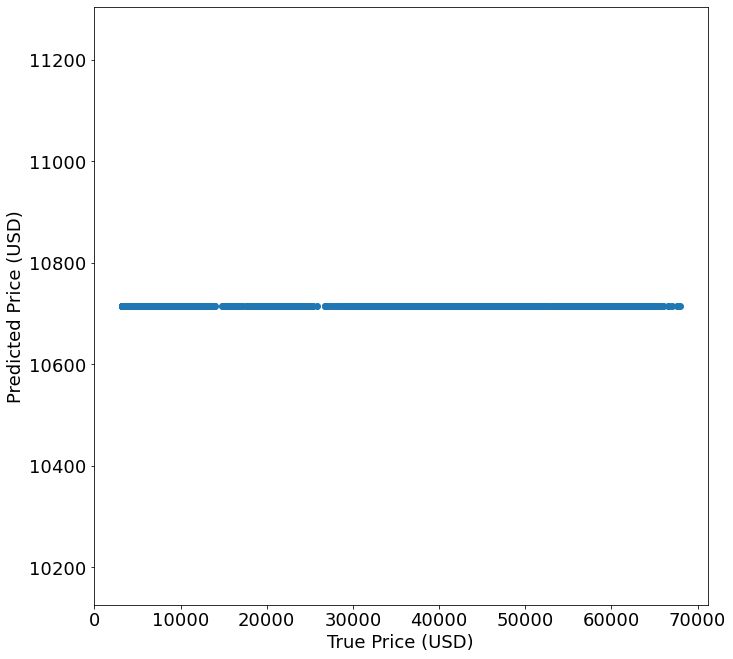

In [18]:
fig = plt.figure(figsize=(11,11))
plt.scatter(val_y, pred)
plt.xlabel('True Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.show()

In [19]:
pred.min()

10715.333

In [20]:
pred.max()

10715.333

In [21]:
bitcoin_model.save("saved_models/1/")

INFO:tensorflow:Assets written to: saved_models/1/assets


INFO:tensorflow:Assets written to: saved_models/1/assets
